In [1]:
!pip install google-cloud-bigquery wordcloud matplotlib pandas


In [14]:
from google.cloud import bigquery
import pandas as pd
from google.oauth2 import service_account
# Chemin vers ta clé JSON
KEY_PATH = "cle_bigquery.json"

# Authentification
credentials = service_account.Credentials.from_service_account_file(KEY_PATH)

# Création du client BigQuery
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Test : afficher les datasets de ton projet
for dataset in client.list_datasets():
    print("Dataset trouvé :", dataset.dataset_id)

Dataset trouvé : dataset_airflow
Dataset trouvé : dataset_image
Dataset trouvé : dataset_raw
Dataset trouvé : dataset_transformed_by_dbt
Dataset trouvé : dbt_khamam
Dataset trouvé : dbt_nbennettayeb
Dataset trouvé : dev_jeanlaurent
Dataset trouvé : dev_sbeghin
Dataset trouvé : tests


In [15]:
 
query = """
WITH base AS (
    SELECT
        id_commande,
        commentaire,
        note_client,
        CASE 
            WHEN note_client >= 3 THEN 'positif'
            WHEN note_client <= 2 THEN 'negatif'
            ELSE 'neutre'
        END AS sentiment
    FROM `carttrend-460508.dbt_khamam.mrt_fct_satisfaction`
    WHERE commentaire IS NOT NULL
),

replaced AS (
    SELECT
        id_commande,
        commentaire,
        note_client,
        sentiment,
        CASE
            WHEN LOWER(commentaire) LIKE '%better%' THEN 'passable'
            WHEN LOWER(commentaire) LIKE '%excellent product%' THEN 'excellent'
            WHEN LOWER(commentaire) LIKE '%fast delivery%' THEN 'efficient'
            WHEN LOWER(commentaire) LIKE '%good product%' THEN 'satisfying'
            WHEN LOWER(commentaire) LIKE '%average product%' THEN 'average'
            WHEN LOWER(commentaire) LIKE '%below average%' THEN 'poor'
            WHEN LOWER(commentaire) LIKE '%delivery took too long%' THEN 'slow'
            WHEN LOWER(commentaire) LIKE '%not satisfied%' THEN 'unsatisfied'
            WHEN LOWER(commentaire) LIKE '%terrible experience%' THEN 'terrible'
            WHEN LOWER(commentaire) LIKE '%great quality%' THEN 'great'
            WHEN LOWER(commentaire) LIKE '%okay%' THEN 'bof'
            WHEN LOWER(commentaire) LIKE '%product arrived damaged%' THEN 'damaged'
            WHEN LOWER(commentaire) LIKE '%perfect experience%' THEN 'perfect'
            WHEN LOWER(commentaire) LIKE '%satisfied with the experience%' THEN 'satisfied'
            WHEN LOWER(commentaire) LIKE '%Customer service was unhelpful%' THEN 'bad'
            ELSE 'bad'
        END AS mots_cles
    FROM base
)

SELECT
    sentiment,
    mots_cles,
    COUNT(*) AS frequence
FROM replaced
WHERE sentiment IN ('positif', 'negatif')
GROUP BY sentiment, mots_cles
ORDER BY sentiment, frequence DESC
"""
# Exécution de la requête
df = client.query(query).to_dataframe()

# Affichage des premiers résultats
print(df.head())

  sentiment    mots_cles  frequence
0   negatif          bad        340
1   negatif     terrible        332
2   negatif         poor        329
3   negatif  unsatisfied        326
4   negatif         slow        319


C:\Users\kahin\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


C:\Users\kahin\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


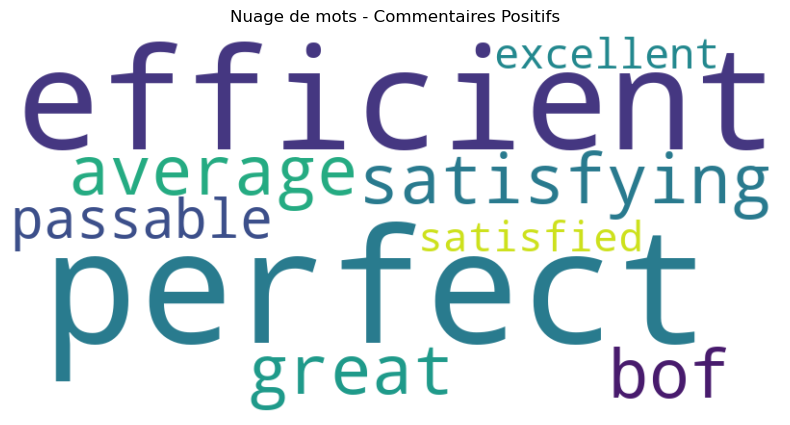

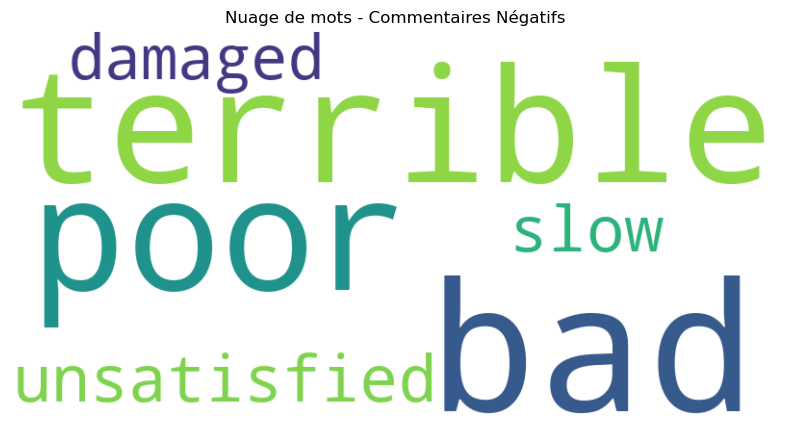

In [16]:
# Exécuter la requête
df = client.query(query).to_dataframe()

# Fonction pour créer un nuage de mots à partir d'un DataFrame filtré sur un sentiment
def plot_wordcloud(data, sentiment):
    # Créer un dictionnaire mots -> fréquences
    freqs = dict(zip(data['mots_cles'], data['frequence']))
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)

    plt.figure(figsize=(10, 5))
    plt.title(f"Nuage de mots - Commentaires {sentiment}")
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Nuage pour les commentaires positifs
df_positif = df[df['sentiment'] == 'positif']
plot_wordcloud(df_positif, 'Positifs')

# Nuage pour les commentaires négatifs
df_negatif = df[df['sentiment'] == 'negatif']
plot_wordcloud(df_negatif, 'Négatifs')

In [17]:
!pip install wordcloud


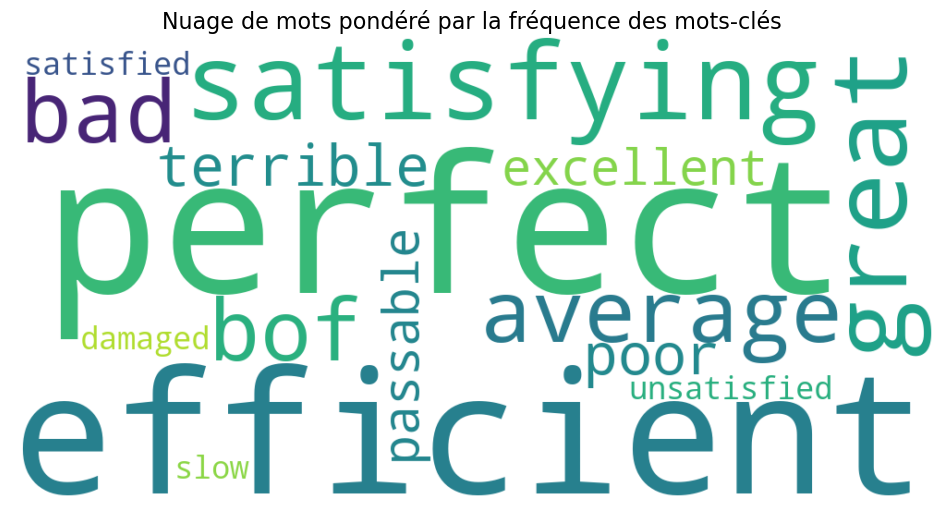

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Création d’un dictionnaire {mot_clé: fréquence}
frequences_dict = df.dropna(subset=["mots_cles", "frequence"]) \
                    .groupby("mots_cles")["frequence"].sum().to_dict()

# Génération du nuage de mots à partir des fréquences
wordcloud = WordCloud(width=1000, height=500, background_color='white') \
    .generate_from_frequencies(frequences_dict)

# Affichage
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots pondéré par la fréquence des mots-clés", fontsize=16)
plt.show()


In [19]:
# Affichage simple des mots-clés les plus fréquents

def afficher_top_mots(df, sentiment, top_n=10):
    df_sent = df[df["sentiment"] == sentiment]
    print(f"\nTop {top_n} mots-clés dans les commentaires {sentiment} :")
    display(df_sent.sort_values("frequence", ascending=False).head(top_n))

# Top mots-clés positifs
afficher_top_mots(df, "positif")

# Top mots-clés négatifs
afficher_top_mots(df, "negatif")



Top 10 mots-clés dans les commentaires positif :


,sentiment,mots_cles,frequence
6,positif,perfect,361
7,positif,efficient,350
8,positif,satisfying,350
9,positif,great,346
10,positif,average,344
11,positif,bof,333
12,positif,passable,326
13,positif,excellent,326
14,positif,satisfied,305



Top 10 mots-clés dans les commentaires negatif :


,sentiment,mots_cles,frequence
0,negatif,bad,340
1,negatif,terrible,332
2,negatif,poor,329
3,negatif,unsatisfied,326
4,negatif,slow,319
5,negatif,damaged,313


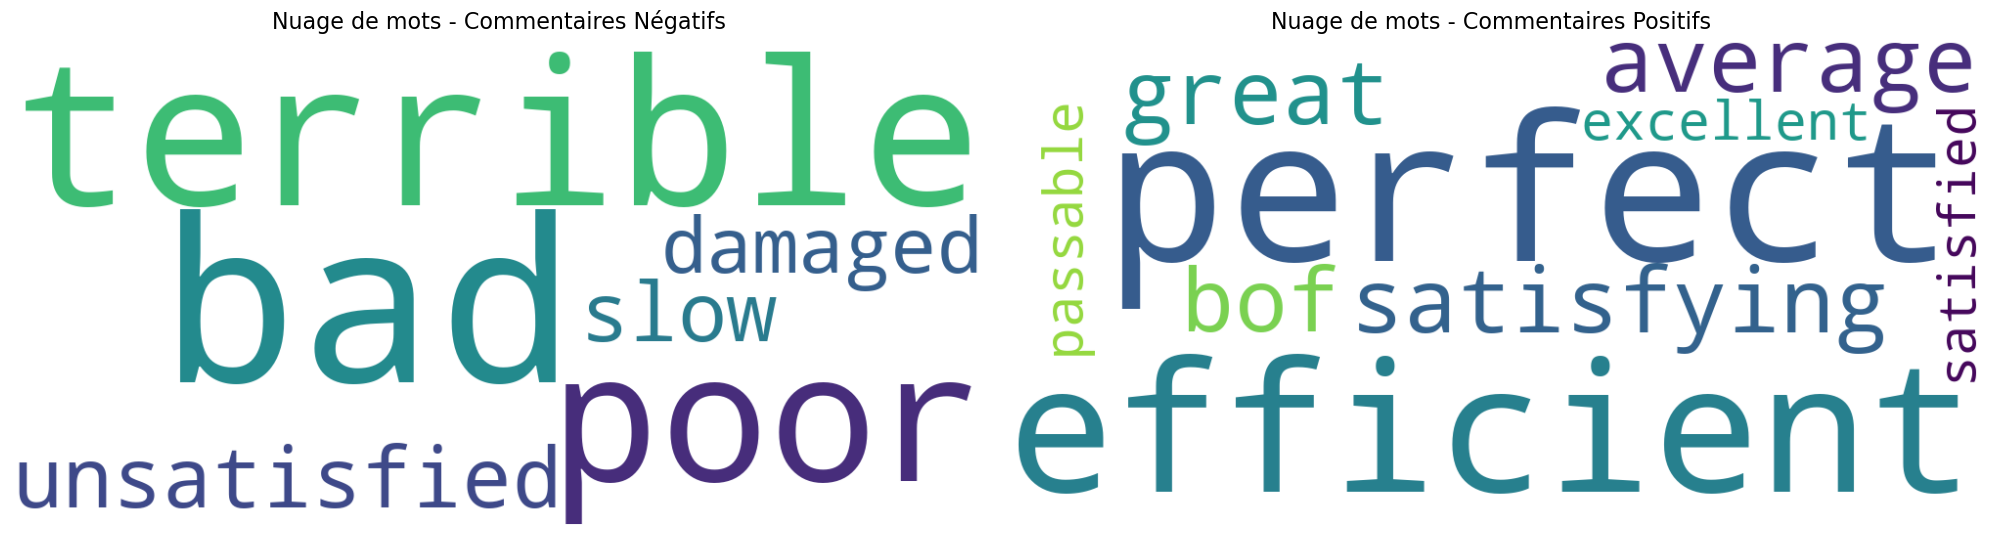

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Dictionnaires de fréquences
neg_freq = (
    df[df["sentiment"] == "negatif"]
    .groupby("mots_cles")["frequence"]
    .sum()
    .to_dict()
)

pos_freq = (
    df[df["sentiment"] == "positif"]
    .groupby("mots_cles")["frequence"]
    .sum()
    .to_dict()
)

# Génération des nuages de mots (sans colormap = style par défaut)
neg_wc = WordCloud(width=1000, height=500, background_color='white') \
    .generate_from_frequencies(neg_freq)

pos_wc = WordCloud(width=1000, height=500, background_color='white') \
    .generate_from_frequencies(pos_freq)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(neg_wc, interpolation='bilinear')
axes[0].axis("off")
axes[0].set_title("Nuage de mots - Commentaires Négatifs", fontsize=16)

axes[1].imshow(pos_wc, interpolation='bilinear')
axes[1].axis("off")
axes[1].set_title("Nuage de mots - Commentaires Positifs", fontsize=16)

plt.tight_layout()
plt.show()


In [21]:
# Sauvegarde des nuages de mots au format PNG
neg_wc.to_file("nuage_mots_negatifs.png")
pos_wc.to_file("nuage_mots_positifs.png")
